<a href="https://colab.research.google.com/github/Jeevankranth/Exploratory-Data-Analysis/blob/main/classification_news_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import re


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')

2024-05-14 18:04:47.379815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 18:04:47.379921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 18:04:47.505102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**visulizing the first 20 words of first True new**

lets just see what is our csv files like

In [ ]:
true_df = pd.read_csv('/content/True.csv')
fake_df = pd.read_csv('/content/Fake.csv')

visualize = ''
counter = 0

for i in  true_df['text'][1].split(' '):
    visualize = visualize + i + " "
    if counter>20:
        break
    counter = counter + 1


print('a sample true news(only 20 first words):\n\n', visualize)

a sample true news(only 20 first words):

 WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as 


In [ ]:
true_df['labels'] = 1
fake_df['labels'] = 0

news = pd.concat([true_df,fake_df],ignore_index=True).sample(frac = 1)
news.drop(columns = ['title','subject','date'],inplace = True)
print(news.head())
print(news.shape)

                                                    text  labels
44050   21st Century Wire asks HAVE YOUR SHOUT: Frida...       0
32746  Nunes dropped a bombshell that Obama admin spi...       0
36619  Does anyone remember these girls?Dixie who?Jus...       0
19779  BEIRUT (Reuters) - The Deir al-Zor military ai...       1
29046  The GOP is known for its misogyny. This is esp...       0
(44898, 2)


**data cleanning**

In [ ]:
news = news.drop_duplicates()
news.shape

(38647, 2)

**data preprocessing and train , validation ,and test split**

we split data to:
* 70% train
* 15% test
* 15% validation

In [ ]:
texts = news['text'].values
labels = news['labels'].values

#train, validation, and test split
x_train, x_val, y_train, y_val = train_test_split(texts, labels, test_size=0.3, random_state=42, shuffle=True, stratify=None)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42, shuffle=True, stratify=None)

len_y_total = len(y_train)+ len(y_val)+ len(y_test)
print('train data: ', len(y_train),':', len(y_train)/len_y_total *100 , '% ', 'of total dataset')
print('validation data: ', len(y_val),':', len(y_val)/len_y_total *100 , '% ', 'of total dataset')
print('test data: ', len(y_test),':', len(y_test)/len_y_total *100 , '% ', 'of total dataset')

train data:  27052 : 69.99767122933216 %  of total dataset
validation data:  5797 : 14.999870623851786 %  of total dataset
test data:  5798 : 15.002458146816053 %  of total dataset


**data preprocessing**

In [ ]:
def preprocessing(text):
    text = text.lower()

    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
    text = re.sub(r'<.*?>', '', text)

    return text


vectorized = np.vectorize(preprocessing)
x_train = vectorized(x_train)
x_test = vectorized(x_test)
x_val = vectorized(x_val)

print('the first 20 words of first train text after preprocessing:')
visualize = ''
counter = 0
for i in x_train[0].split(' '):
    visualize = visualize + i + " "
    if counter>20:
        break
    counter = counter + 1
print(visualize)

the first 20 words of first train text after preprocessing:
washington reuters a proposal by u s republicans to repeal and replace the obamacare health insurance program suffered serious new setbacks within 


**tokenize and padding process:**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)
val_seq = tokenizer.texts_to_sequences(x_val)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(sequence) for sequence in train_seq)


train_seq = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = 'post')
test_seq = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = 'post')
val_seq = pad_sequences(val_seq, maxlen = max_length, padding = 'post', truncating = 'post')


**creating our model:**

In [ ]:
epochs = 10
lr = 1e-3
embedding_dim = 300
model = Sequential([
    Input(shape = (max_length,)),
    Embedding(vocab_size, embedding_dim, input_length = max_length, trainable = False),

    Bidirectional(LSTM(128, return_sequences = True)),
    Bidirectional(LSTM(64)),
    Dropout(0.2),

    Dense(256, activation = 'relu'),

    Dropout(0.5),

    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = Adam(learning_rate = lr), loss = BinaryCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 7350, 300)      │    29,327,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 7350, 256)      │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,964,629 (114.31 MB)

 Trainable params: 636,929 (2.43 MB)

 Non-trainable params: 29,327,700 (111.88 MB)

**training our model:**

In [ ]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

# train the model

history = model.fit(train_seq, y_train, epochs = epochs,
                    validation_data = (val_seq , y_val), callbacks = [model_es, model_rlr])

Epoch 1/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 832s 977ms/step - accuracy: 0.9393 - loss: 0.1266 - val_accuracy: 0.9976 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 2/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 830s 982ms/step - accuracy: 0.9969 - loss: 0.0135 - val_accuracy: 0.9976 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 3/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 835s 987ms/step - accuracy: 0.9988 - loss: 0.0078 - val_accuracy: 0.9976 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 4/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 835s 987ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9974 - val_loss: 0.0134 - learning_rate: 2.0000e-04


**evaluation:**

**train and test accuracy:**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# get predictions

y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))

# display the accuracy

print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

Train Accuracy : 99.86 %
Test Accuracy  : 99.88 %


**classification reports:**

In [ ]:
# display classification report

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print(40*'-')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12229
           1       1.00      1.00      1.00     14823

    accuracy                           1.00     27052
   macro avg       1.00      1.00      1.00     27052
weighted avg       1.00      1.00      1.00     27052

----------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2602
           1       1.00      1.00      1.00      3196

    accuracy                           1.00      5798
   macro avg       1.00      1.00      1.00      5798
weighted avg       1.00      1.00      1.00      5798



**model history:**

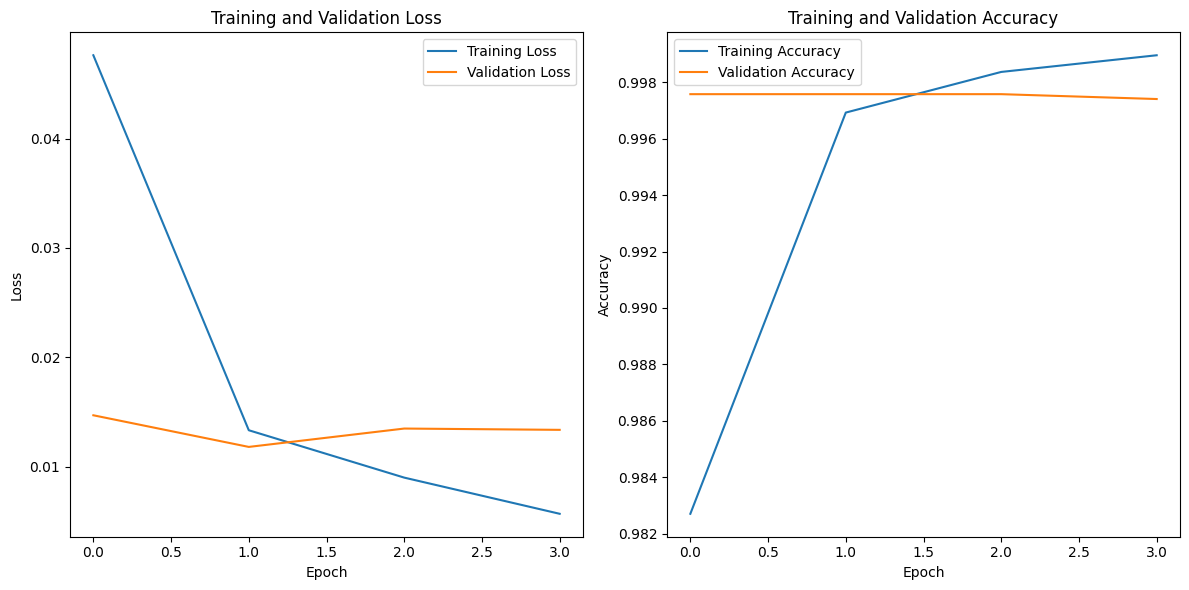

In [ ]:


plt.figure(figsize = (12, 6))

# loss plot

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# accuracy plot

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**confusion matrix:**

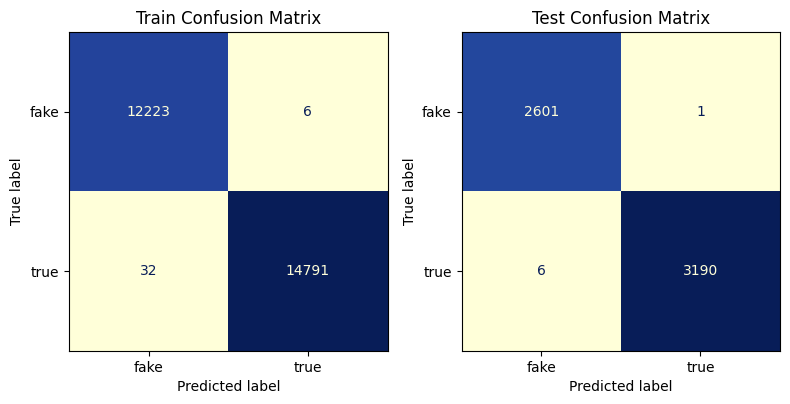

In [ ]:
train_matrix = confusion_matrix(y_train, y_pred_train)
test_matrix = confusion_matrix(y_test, y_pred_test)

class_labels = ['fake', 'true']

disp_train = ConfusionMatrixDisplay(confusion_matrix = train_matrix, display_labels = class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

fig, axs = plt.subplots(1, 2, figsize = (8, 12))

# train

disp_train.plot(ax = axs[0], cmap = 'YlGnBu', colorbar = False)
axs[0].set_title('Train Confusion Matrix')

# test

disp_test.plot(ax = axs[1], cmap = 'YlGnBu', colorbar = False)
axs[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()